In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tqdm import tqdm

In [2]:
load_digits().keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
df = pd.DataFrame(load_digits()['data'], columns=load_digits()['feature_names'])
df['label']=load_digits()['target']

df.shape

(1797, 65)

In [4]:
df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [5]:
df['label'].value_counts()

3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
Name: label, dtype: int64

In [6]:
ranges = list(map(lambda x: np.ptp(df[x]), df.columns))

pd.DataFrame(ranges, index=df.columns, columns=['range'])

,range
pixel_0_0,0.0
pixel_0_1,8.0
pixel_0_2,16.0
pixel_0_3,16.0
pixel_0_4,16.0
...,...
pixel_7_4,16.0
pixel_7_5,16.0
pixel_7_6,16.0
pixel_7_7,16.0


In [7]:
cols = list(df.columns)
cols.remove('label')

X=df[cols]
y=df['label']

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
min_samples = 2*df.shape[1]

Optimizing **eps (epsilon)** hyperparameter of DBSCAN

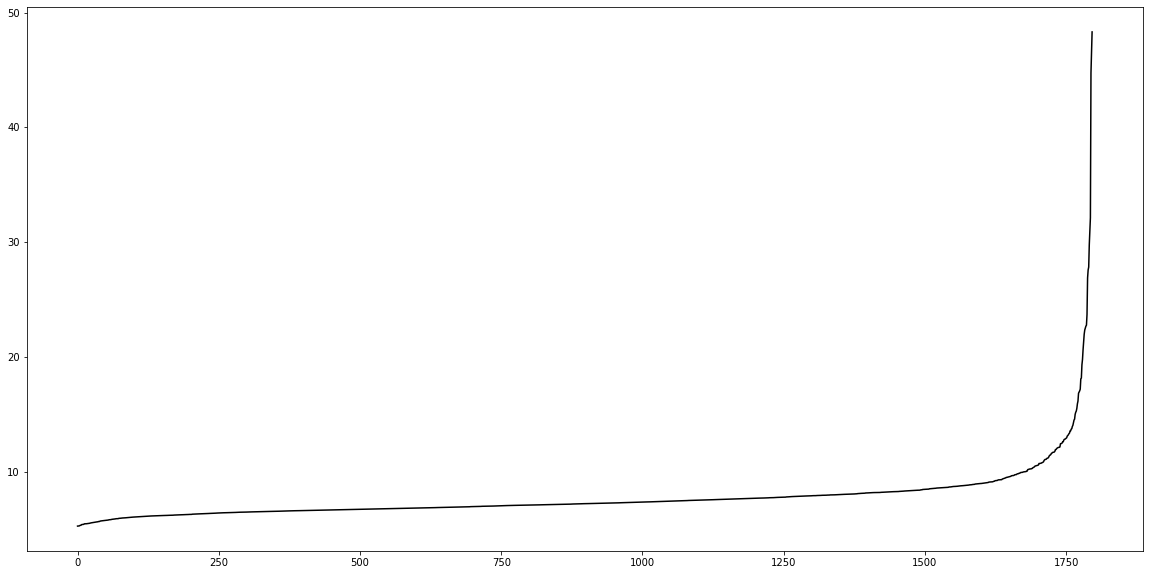

In [10]:
knn = NearestNeighbors(n_neighbors=min_samples)
knn.fit(X)

dist = knn.kneighbors(X)[0]

#kth nearest distance of every point to any other point
dist = np.sort(dist[:,-1])

fig=plt.figure(figsize=(20,10))

plt.plot(dist, c='k')
plt.show()

In [11]:
def calculate_eps(min_samples):
    
    knn = NearestNeighbors(n_neighbors=min_samples)
    knn.fit(X)

    dist = knn.kneighbors(X)[0]

    #kth nearest distance of every point to any other point
    dist = np.sort(dist[:,-1])
    
    df_dist = pd.DataFrame(dist, columns=['distance'])
    df_dist['shifted'] = df_dist.shift(1)

    df_dist['slope'] = df_dist['distance']-df_dist['shifted']
    eps = df_dist['slope'].max()  
    
    return eps

calculate_eps(min_samples=min_samples)

12.613101980666094

In [12]:
def optimize_silhouette_score(min_samples):
    
    eps = calculate_eps(min_samples)
    dbs = DBSCAN(eps=eps, min_samples=min_samples)
    dbs.fit(X)

    labels = dbs.labels_
    
    try:
        return eps, silhouette_score(X,labels)
        
    except Exception as e:
        return eps, -1

In [13]:
min_min_samples = X.shape[1]+1 # general rule of thumb
max_min_samples = 200

max_silhouette_score = -1
best_params = {}
SCORES = []
for min_samples in tqdm(range(min_min_samples, max_min_samples)):

    eps, score = optimize_silhouette_score(min_samples)
    SCORES.append(score)
    
    if (score>max_silhouette_score):
        max_silhouette_score = score

        best_params['eps'] = eps
        best_params['min_samples'] = min_samples 
        
max_silhouette_score, best_params

100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:51<00:00,  2.64it/s]


(0.6585788967475753, {'eps': 12.819429181464212, 'min_samples': 65})

In [14]:
min_samples = best_params['min_samples']
eps = best_params['eps']

eps = calculate_eps(min_samples)
dbs = DBSCAN(eps=eps, min_samples=min_samples)
dbs.fit(X)

labels = dbs.labels_

In [15]:
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(X)

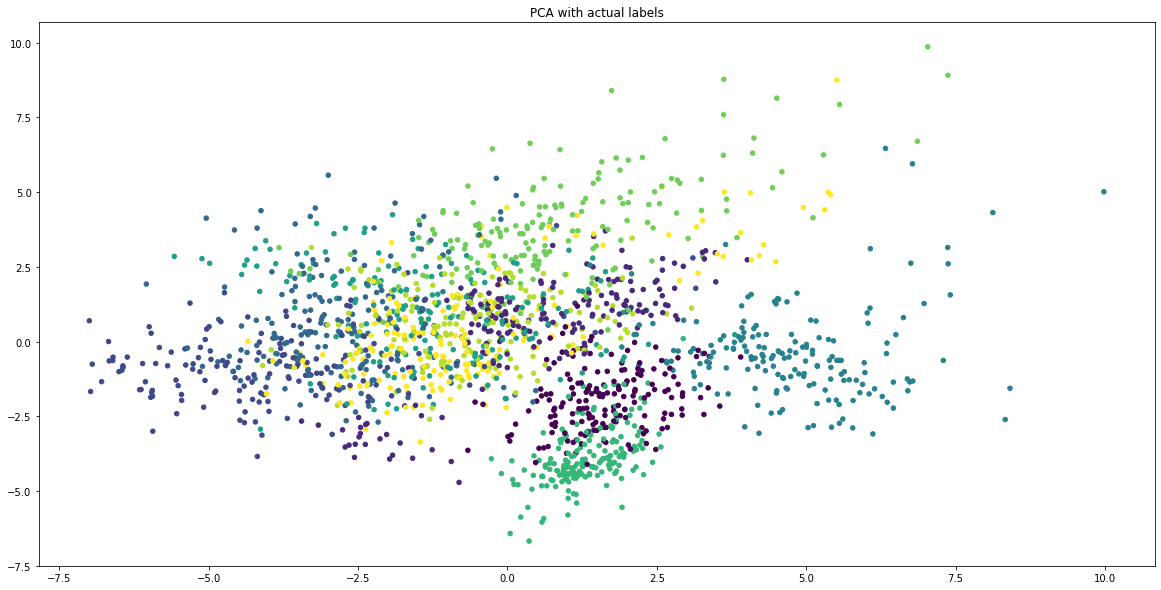

In [16]:
fig = plt.figure(figsize=(20,10))

plt.title('PCA with actual labels')
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=y, s=20)
plt.show()

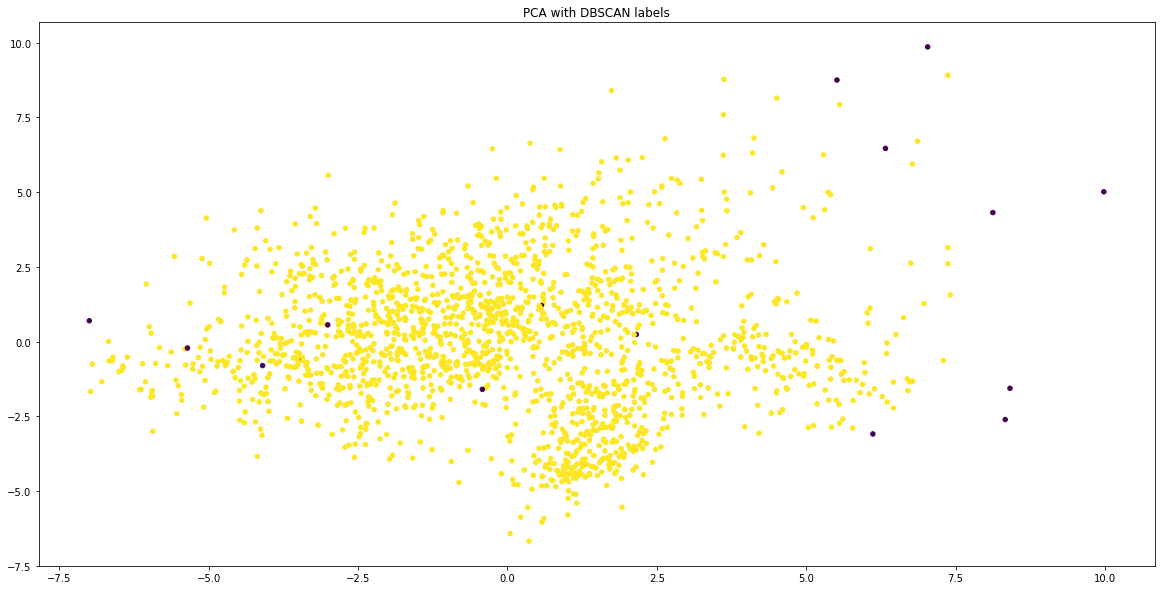

In [17]:
fig = plt.figure(figsize=(20,10))

plt.title('PCA with DBSCAN labels')
plt.scatter(pca_data[:, 0], pca_data[:, 1], s=20, c=labels)
plt.show()

In [18]:
tsne = TSNE(n_components=2)

tsne_data = tsne.fit_transform(X)

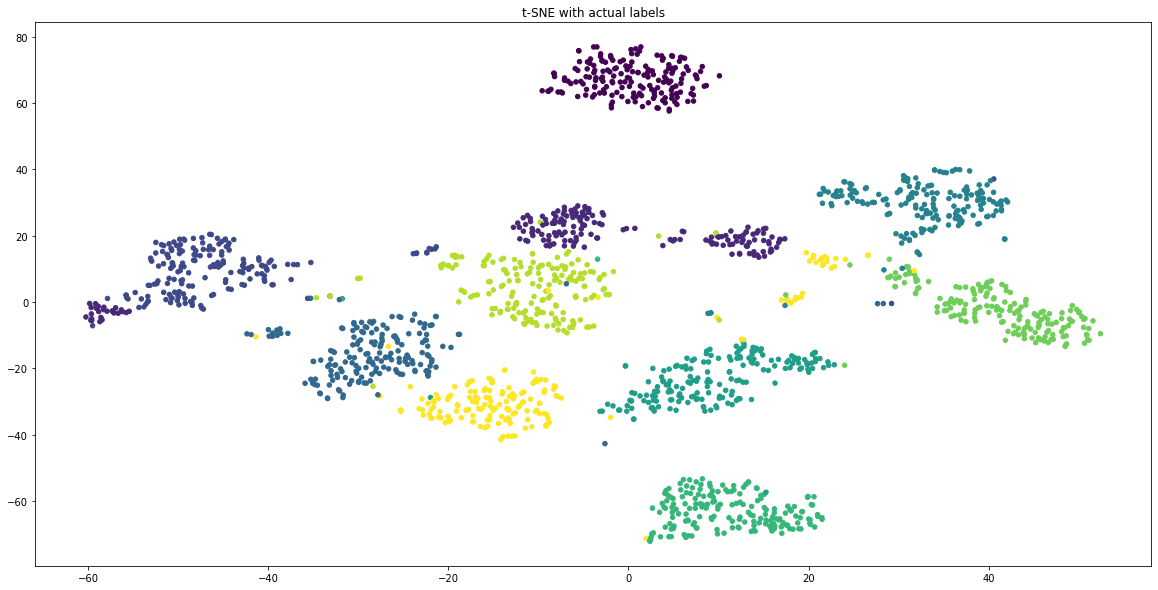

In [19]:
fig = plt.figure(figsize=(20,10))

plt.title('t-SNE with actual labels')
plt.scatter(tsne_data[:,0], tsne_data[:,1], s=20, c=y)
plt.show()

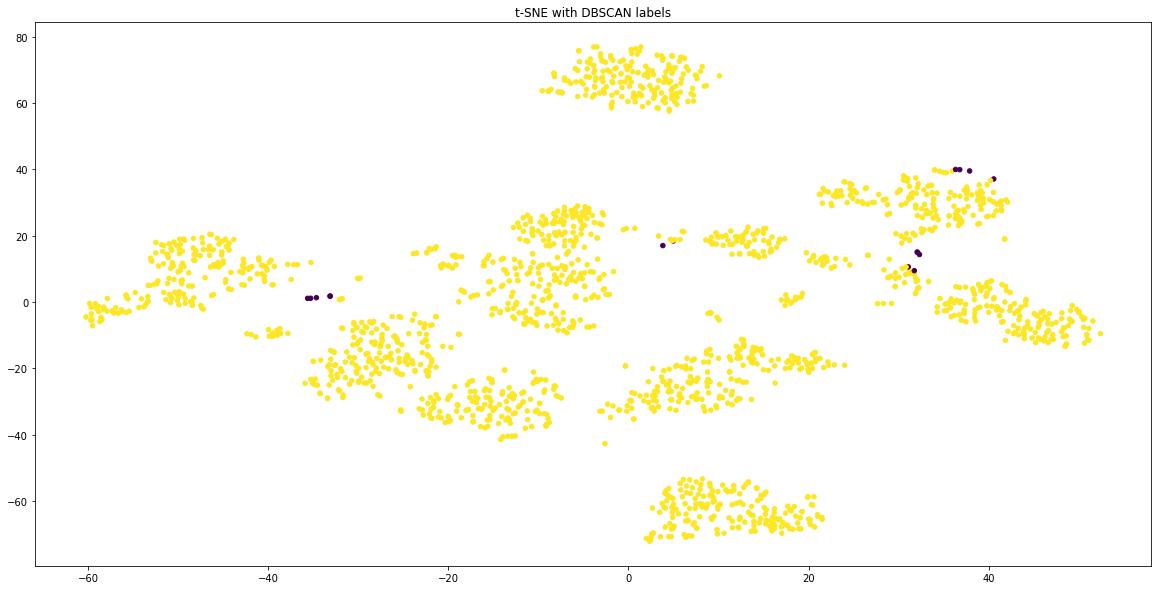

In [20]:
fig = plt.figure(figsize=(20,10))

plt.title('t-SNE with DBSCAN labels')
plt.scatter(tsne_data[:,0], tsne_data[:,1], s=20, c=labels)
plt.show()